In [70]:

import torch
from torch import nn

import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import numpy as np
from sklearn.datasets import make_swiss_roll
import plotly.graph_objects as go
from sklearn.datasets import make_moons



In [71]:
#initialize random 
torch.manual_seed(111)

<center><span style="font-size: 25pt">Generate Synthetic Data</span></center>

Training Data for $x_2 = sinx_1$

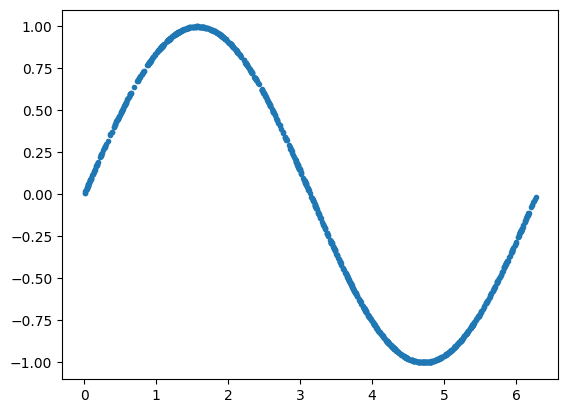

In [72]:
#prepare the training data
train_data_length = 1024
train_data_sin = torch.zeros((train_data_length, 2))
train_data_sin[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data_sin[:, 1] = torch.sin(train_data_sin[:, 0])
train_labels_sin = torch.zeros(train_data_length)
train_set_sin = [
    (train_data_sin[i], train_labels_sin[i]) for i in range(train_data_length)
]
plt.plot(train_data_sin[:, 0], train_data_sin[:, 1], ".")

Training Data for $x_1^2 + x_2^2 =1$

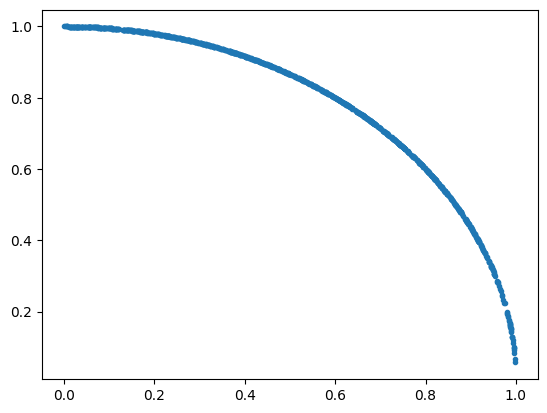

In [73]:
train_data_circle = torch.zeros((train_data_length, 2))
train_data_circle[:, 0] = torch.rand(train_data_length)  
train_data_circle[:, 1] = torch.sqrt(1 - train_data_circle[:, 0]**2)  
train_labels_circle = torch.zeros(train_data_length)
train_set_circle = [
    (train_data_circle[i], train_labels_circle[i]) for i in range(train_data_length)
]

plt.plot(train_data_circle[:, 0], train_data_circle[:, 1], ".")

Using make_circles

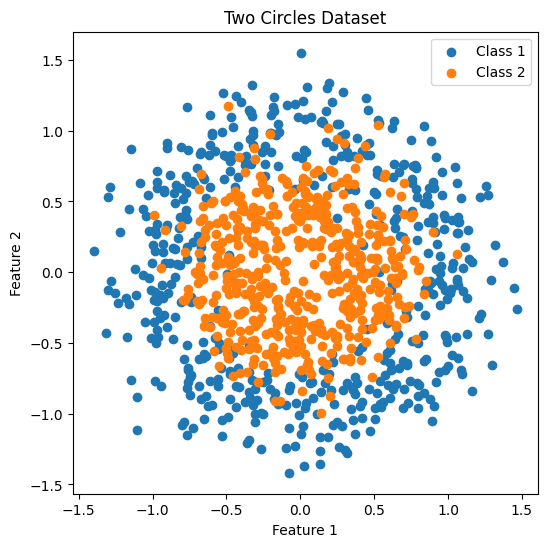

In [74]:
X, y = make_circles(n_samples=train_data_length, noise=0.2, factor=0.5)
class_1 = X[y == 0]
class_2 = X[y == 1]

plt.figure(figsize=(6, 6))
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1')
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Two Circles Dataset')
plt.legend()
plt.show()



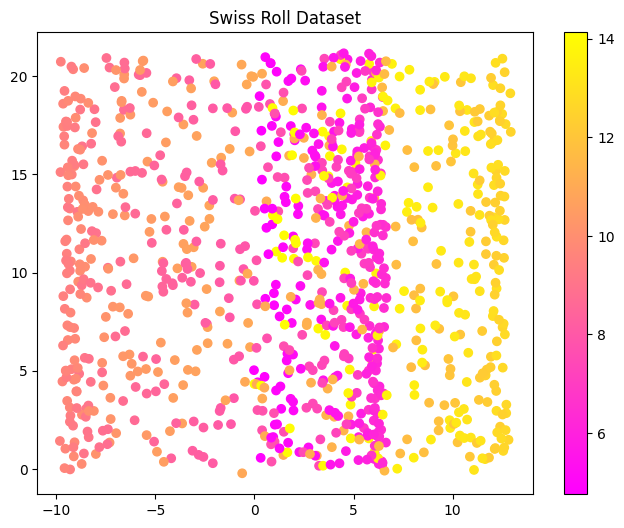

In [75]:
X, color = make_swiss_roll(n_samples=train_data_length, noise=0.2, random_state=42)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.spring)
plt.title('Swiss Roll Dataset')
plt.colorbar()
plt.show()

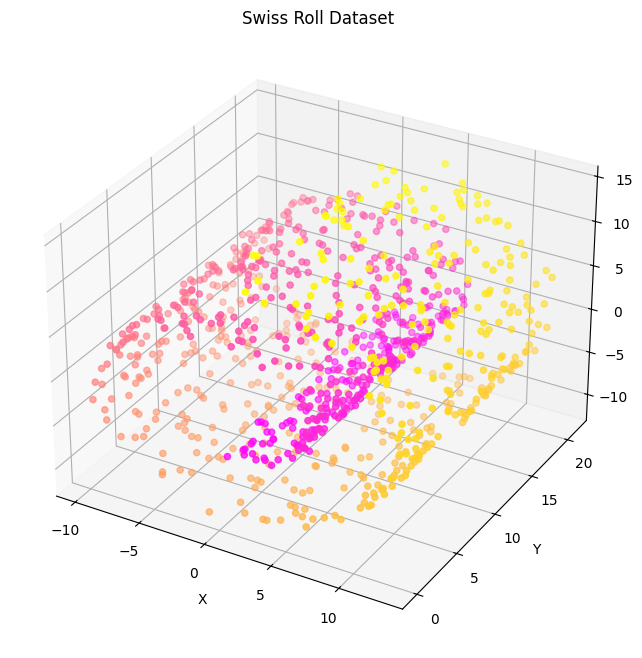

In [76]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.spring)
ax.set_title('Swiss Roll Dataset')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


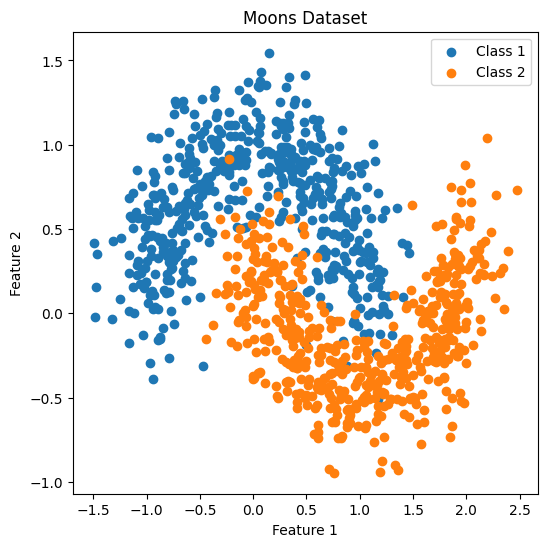

In [78]:
X, y = make_moons(n_samples=train_data_length, noise=0.2, random_state=42)

class_1 = X[y == 0]
class_2 = X[y == 1]

plt.figure(figsize=(6, 6))
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1')
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Moons Dataset')
plt.legend()
plt.show()

<center><span style="font-size: 30pt">Generative Adversarial Network Code</span></center>

In [79]:
#load data into the pytorch data loader
batch_size = 32
train_loader_sin = torch.utils.data.DataLoader(
    train_set_sin, batch_size=batch_size, shuffle=True
)

In [80]:
#implement the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256), #the input is two-dimensional
            nn.ReLU(),
            nn.Dropout(0.3), #droput layers reduce overfitting
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),#sigmoid activation to represent probability
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [81]:
#implement the generator
class Generator(nn.Module):
     def __init__(self):
         super().__init__()
         self.model = nn.Sequential(
             nn.Linear(1, 16),
             nn.ReLU(),
             nn.Linear(16, 32),
             nn.ReLU(),
             nn.Linear(32, 2),
         )

     def forward(self, x):
         output = self.model(x)
         return output

In [82]:
loss_function = nn.BCELoss() #binary cross entropy loss
#Cross entropy loss measures the difference between the discovered probability distribution
#of a machine learning classification model and the predicted distribution.
#measures how well a classification model performs

Epoch: 0 Loss D.: 0.21269650757312775
Epoch: 0 Loss G.: 3.385101318359375


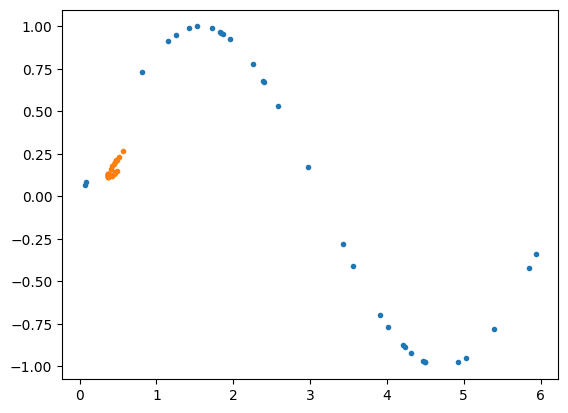

Epoch: 100 Loss D.: 0.6801981329917908
Epoch: 100 Loss G.: 0.8988490104675293


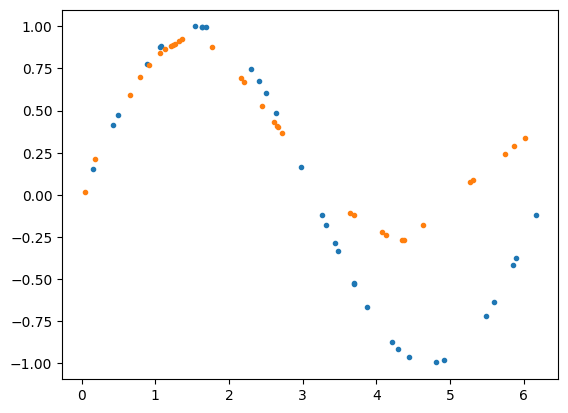

Epoch: 200 Loss D.: 0.662980318069458
Epoch: 200 Loss G.: 0.6947572231292725


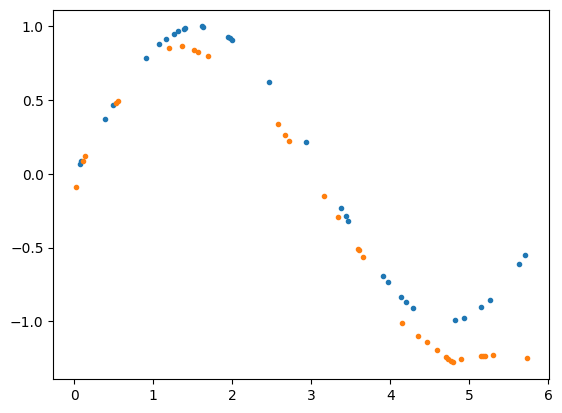

Epoch: 300 Loss D.: 0.6852405667304993
Epoch: 300 Loss G.: 0.7220438718795776


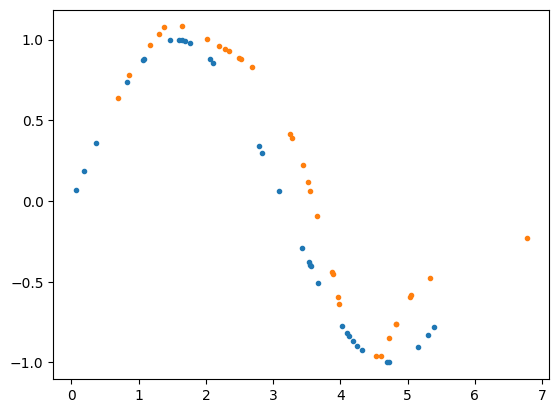

Epoch: 400 Loss D.: 0.677912712097168
Epoch: 400 Loss G.: 0.7825422286987305


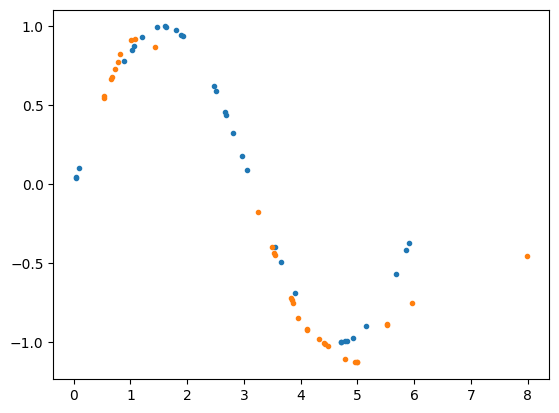

In [83]:
#training loop for the GAN
num_epochs = 400
lr_g=0.001
lr_d=0.0015
discriminator = Discriminator()
generator = Generator()
gen_loss_vector = []
discr_loss_vector= []
num_epoch_vector = []
#use Adam algorithm to update weights of numerator and discriminator
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_d)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_g)

for epoch in range(num_epochs+1):
    for n, (real_samples, _) in enumerate(train_loader_sin):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 1))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))      
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )
        #differentiate between real and generated samples

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 1))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        
        output_discriminator_generated = discriminator(generated_samples)
        #want to minimized generator loss
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        #discriminateor weights frozen since optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            gen_loss_vector.append(float(loss_generator))
            discr_loss_vector.append(float(loss_discriminator))
            num_epoch_vector.append(epoch)
        if epoch % 100 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            
            generated_samples_for_plotting = generated_samples.detach()
            plt.figure()
            plt.plot(real_samples[:, 0], real_samples[:, 1], ".")
            plt.plot(generated_samples_for_plotting[:, 0], generated_samples_for_plotting[:, 1], ".")
            plt.show()
            

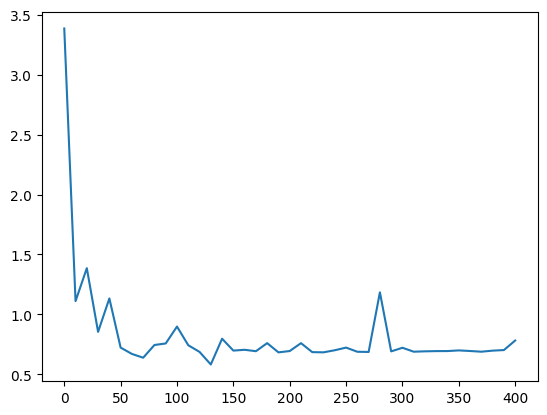

In [84]:
#generator loss
plt.plot(num_epoch_vector, gen_loss_vector) 
plt.show()

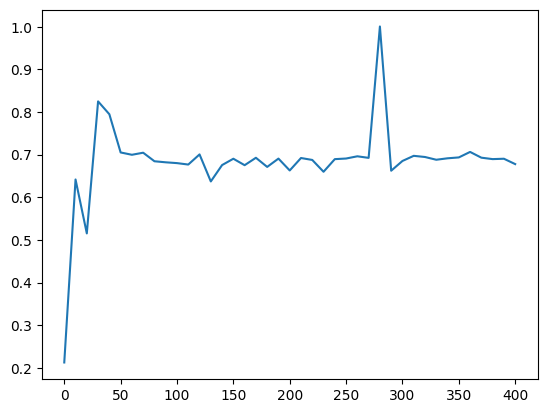

In [85]:
#discriminator loss
plt.plot(num_epoch_vector, discr_loss_vector) 
plt.show()